<a href="https://colab.research.google.com/github/ramrajv/AI_Fin/blob/main/YF_Indian_Buy_Sell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import time
import requests
import io

In [2]:
url = 'https://raw.githubusercontent.com/ramrajv/AI_Fin/main/YF_Stock_Codes.csv'
df = pd.read_csv(url)

In [3]:
df.head

<bound method NDFrame.head of          YF_Symbol       SC_NAME
0        500002.BO  ABB LTD.    
1        500003.BO  AEGIS LOGIS 
2        500008.BO  AMAR RAJA BA
3        500009.BO  A.SARABHAI  
4        500010.BO  HDFC        
...            ...           ...
6588       ZOTA.NS          ZOTA
6589      ZUARI.NS         ZUARI
6590   ZUARIIND.NS      ZUARIIND
6591  ZYDUSLIFE.NS     ZYDUSLIFE
6592  ZYDUSWELL.NS     ZYDUSWELL

[6593 rows x 2 columns]>

## Historical Market Prices

Get the historical market prices of 90days

In [4]:
end = datetime.date.today()
start = end-pd.Timedelta(days = 90)


In [5]:
Symbols = df['YF_Symbol'].tolist()

In [7]:
# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:

    # print the symbol which is being downloaded
    # print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)

    try:
        # download the stock price
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)

        # append the individual stock prices
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

Streaming output truncated to the last 5000 lines.
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AXISTECET.NS']: Exception('%ticker%: No timezone found, symbol may be delisted')
<ipython-input-7-339dfe61493d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock,sort=False)
<ipython-input-7-339dfe61493d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock,sort=False)
<ipython-input-7-339dfe61493d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock,sort=False)
<ipython-input-7-339dfe61493d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

In [17]:
stock_final.reset_index(inplace = True)
stock_final.set_index(pd.DatetimeIndex(stock_final['Date'].values))

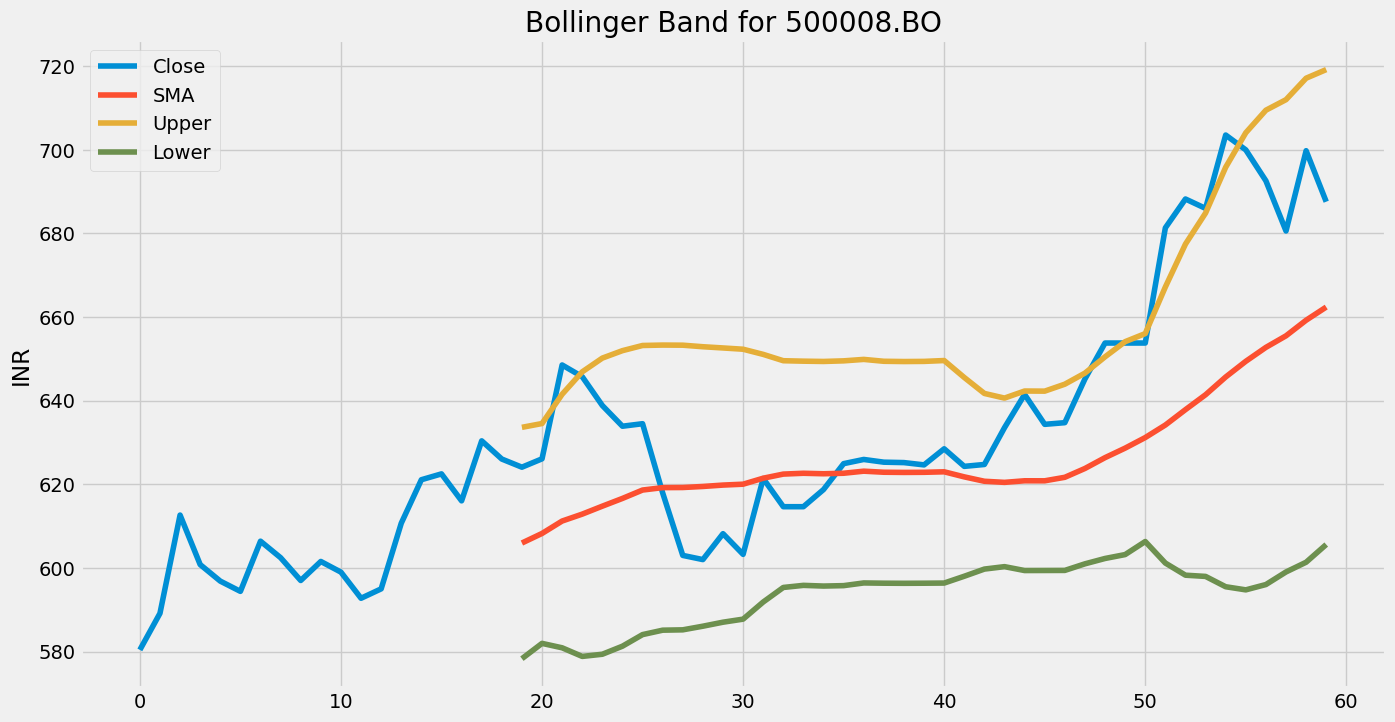

In [19]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Calculate the simple moving average, standard deviation, upper band and the lower band
# Get the time period (20days)

period = 20

# calculate the Simple Moving Average (SMA)
stock_final['SMA'] = stock_final['Close'].rolling(window = period).mean()

# Get the Standard Deviation
stock_final['STD'] = stock_final['Close'].rolling(window = period).std()

# Calculate the upper Bolinger band
stock_final['Upper'] = stock_final['SMA'] + (stock_final['STD'] * 2)

# Calculate the lower Bolinger band
stock_final['Lower'] = stock_final['SMA'] - (stock_final['STD'] * 2)

# Create a list of columns to keep
cols = ['Close','SMA','Upper','Lower']

# plot the data
# stocks = stock_final['Name']
# for stock in stocks:
#     df = stock_final[stock_final['Name']==stock]
#     df[cols].plot(figsize = (15,8))
#     plt.title('Bollinger Band for '+stock)
#     plt.ylabel('INR')
#     plt.show()
#     break

In [55]:
stocks = stock_final['Name'].unique()
new_df = pd.DataFrame()

for stock in stocks:
    df = stock_final[stock_final['Name']==stock]
    new_df = pd.concat([new_df,df[period-1:]])

In [57]:
# new_df = df[period-1:]
new_df.loc[new_df['Close']<new_df['Lower'],'Buy'] = new_df['Close']
# new_df.loc[new_df['Close']<new_df['Upper'],'Buy'] = np.nan
new_df.loc[new_df['Close']>new_df['Upper'],'Sell'] = new_df['Close']
# new_df.loc[new_df['Close']>new_df['Upper'],'Sell'] = np.nan

In [63]:
buy_stocks = new_df[
    (new_df['Date']==end) &
    (new_df['Buy'].notna())
][['Name','Close','Date']]
buy_stocks['action'] = 'Buy'

In [62]:
sell_stocks = new_df[
    (new_df['Date']==end) &
    (new_df['Sell'].notna())
][['Name','Close','Date']]
sell_stocks['action'] = 'Sell'

In [64]:
action_stocks = pd.concat([buy_stocks,sell_stocks])

In [65]:
action_stocks

,Name,Close,Date,action


In [66]:
# # Plot all of the data
# # Ge the figure and the figure size
# fig = plt.figure(figsize = (12.2, 6.4))
# # Add the subplot
# ax = fig.add_subplot(1,1,1)
# # Get the index values of the data frame
# x_axis = new_df['Date']
# # Plot and shade the area betwen the upper band and the lower band grey
# ax.fill_between(x_axis, new_df['Upper'], new_df['Lower'], color = 'grey')
# # Plot the closing price and the moving average
# ax.plot(x_axis, new_df['Close'], color = 'gold', lw = 3, label = 'Close Price', alpha = 0.5)
# ax.plot(x_axis, new_df['SMA'], color = 'blue', lw = 3, label = 'Simple Moving Average', alpha = 0.5)
# ax.scatter(x_axis, new_df['Buy'], color = 'green', lw = 3, label = 'Buy', marker = '^', alpha = 1)
# ax.scatter(x_axis, new_df['Sell'], color = 'red', lw = 3, label = 'Sell',marker = 'v', alpha = 1)
# # set the title and show the image
# ax.set_title('Bollinger band for '+new_df['Name'].iloc[0])
# ax.set_xlabel('Date')
# ax.set_ylabel('INR')
# plt.xticks(rotation = 45)
# ax.legend()
# plt.show()

